# PRACTICE \#2: Generative Adversarial Networks (GANs)
## Course: Advanced Computer Vision

## Student

| ID | Name | Class |
| --- | --- | --- |
| 21127240 | Nguyễn Phát Đạt | HP2-K33|

## Instructors

* Ly Quoc Ngoc
* Nguyen Manh Hung

## Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

Mounted at /content/drive


## Load data

In [ ]:
BATCH_SIZE = 64

In [ ]:
location_path = "/content/drive/MyDrive/Advanced Computer Vision/data"

# Load the dataset
dataset = torchvision.datasets.MNIST(root=location_path,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))]),
                                      download=True)

total_size = len(dataset)
test_size = int(0.01 * total_size)
train_size = total_size - test_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total dataset size: {total_size}')
print(f'Training dataset size: {train_size}')
print(f'Test dataset size: {test_size}')

Total dataset size: 60000
Training dataset size: 59400
Test dataset size: 600


Let's view some samples

In [ ]:
df = pd.DataFrame({"img": pd.Series([img.flatten() for img in train_dataset.dataset.data.numpy()]),
                   "label": train_dataset.dataset.targets.numpy()})

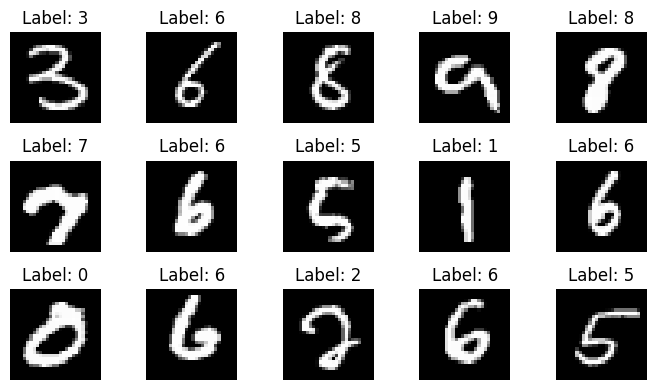

In [ ]:
rows = 3
cols = 5

samples = df.sample(rows * cols)

fig, axes = plt.subplots(rows, cols, figsize=(7, 4), sharex=True, sharey=True)

for i in range(rows):
    for j in range(cols):
        sample = samples.iloc[i * cols + j]
        axes[i, j].imshow(sample['img'].reshape(28, 28), cmap="gray")
        axes[i, j].set_title(f"Label: {sample['label']}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## Construct model

### Hyperparameters

In [ ]:
EPOCHS = 200
DROPOUT_RATE = 0.3

# Optimizer
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

# Discriminator
D_INPUT_DIM = 784
D_HIDDEN_DIMS = [1024, 512, 256]
D_OUTPUT_DIM = 1

# Generator
G_INPUT_DIM = 100
G_HIDDEN_DIMS = D_HIDDEN_DIMS[::-1] # reverse of discriminator
G_OUTPUT_DIM = D_INPUT_DIM

### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(Generator, self).__init__()

        self.input_dim = input_dim

        layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                # First layer from input_dim to the first hidden_dim
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                # Subsequent layers
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))

            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Tanh())

        self.main = nn.Sequential(*layers)

    def forward(self, z):
        return self.main(z).unsqueeze(1)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(Discriminator, self).__init__()

        layers = []

        for i in range(len(hidden_dims)):
            if i == 0:
                # First layer from input_dim to the first hidden_dim
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                # Subsequent layers
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))

            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.main = nn.Sequential(*layers)

    def forward(self, z):
        if z.ndim == 4:
            z = z.view(z.size(0), 1, -1)
        return self.main(z).squeeze(dim=-1)

### Inittialize

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

D = Discriminator(input_dim=D_INPUT_DIM, hidden_dims=D_HIDDEN_DIMS, output_dim=D_OUTPUT_DIM, dropout_rate=DROPOUT_RATE).to(device)

G = Generator(input_dim=G_INPUT_DIM, hidden_dims=G_HIDDEN_DIMS, output_dim=G_OUTPUT_DIM, dropout_rate=DROPOUT_RATE).to(device)

Device:  cuda


### Optimizer

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
G_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

### Loss

In [ ]:
def calc_real_loss(D_output, device, label_smoothing=False):
    real_label = torch.ones(D_output.size(0), 1, device=device)
    if label_smoothing:
        real_label = real_label * 0.9
    criterion = nn.BCELoss()
    return criterion(D_output, real_label)

def calc_fake_loss(D_output, device):
    fake_label = torch.zeros(D_output.size(0), 1, device=device)
    criterion = nn.BCELoss()
    return criterion(D_output, fake_label)

## Train

In [ ]:
training_losses = []
# create a fixed noise to print the generation process later
fixed_noise = torch.randn([BATCH_SIZE, G_INPUT_DIM], device=device)
training_generations = []

n_batches = len(train_dataloader)

for epoch in range(EPOCHS):
    for i, (real_imgs, _) in enumerate(train_dataloader):
        real_imgs = real_imgs.to(device)
        # STEP1: Discriminator optimization
        # Reset gradients
        D_optimizer.zero_grad()

        # 1. real images
        D_real = D(real_imgs)

        d_real_loss = calc_real_loss(D_real, device=device, label_smoothing=True)

        # 2. fake images
        z = torch.randn([real_imgs.size(0), G_INPUT_DIM], device=device)
        fake_images = G(z).detach()
        D_fake = D(fake_images)

        d_fake_loss = calc_fake_loss(D_fake, device=device)
        # add up loss
        lossD = d_real_loss + d_fake_loss
        lossD.backward()
        D_optimizer.step()

        # STEP2: Generator optimization
        # Reset gradients
        G_optimizer.zero_grad()

        z = torch.randn([real_imgs.size(0), G_INPUT_DIM], device=device)
        fake_img = G(z)

        fake_pred = D(fake_img)

        lossG = calc_real_loss(fake_pred, device=device)
        lossG.backward()
        G_optimizer.step()


        if i % 300 == 0 and epoch % 10 == 0: # print d_loss and g_loss
                print(f'[Epoch {epoch+1:3d} / {EPOCHS}] [Batch {i+1:5d} / {n_batches}] [D_loss: {lossD.item():.4f}] [G_loss: {lossG.item():.4f}]')

    training_losses.append((lossD.item(), lossG.item()))

    # generations
    G.eval()
    samples_z = G(fixed_noise)
    training_generations.append(samples_z)
    G.train() # back to train mode


[Epoch   1 / 200] [Batch     1 / 929] [D_loss: 1.3830] [G_loss: 0.6635]
[Epoch   1 / 200] [Batch   301 / 929] [D_loss: 0.6589] [G_loss: 3.4441]
[Epoch   1 / 200] [Batch   601 / 929] [D_loss: 1.0484] [G_loss: 2.8296]
[Epoch   1 / 200] [Batch   901 / 929] [D_loss: 0.6813] [G_loss: 2.8568]
[Epoch  11 / 200] [Batch     1 / 929] [D_loss: 1.2592] [G_loss: 1.6867]
[Epoch  11 / 200] [Batch   301 / 929] [D_loss: 0.9202] [G_loss: 1.6650]
[Epoch  11 / 200] [Batch   601 / 929] [D_loss: 1.0519] [G_loss: 1.3081]
[Epoch  11 / 200] [Batch   901 / 929] [D_loss: 1.1481] [G_loss: 1.1666]
[Epoch  21 / 200] [Batch     1 / 929] [D_loss: 1.5577] [G_loss: 0.9051]
[Epoch  21 / 200] [Batch   301 / 929] [D_loss: 1.1515] [G_loss: 1.1051]
[Epoch  21 / 200] [Batch   601 / 929] [D_loss: 1.1979] [G_loss: 1.5372]
[Epoch  21 / 200] [Batch   901 / 929] [D_loss: 1.1996] [G_loss: 1.1276]
[Epoch  31 / 200] [Batch     1 / 929] [D_loss: 1.0804] [G_loss: 1.2834]
[Epoch  31 / 200] [Batch   301 / 929] [D_loss: 1.1597] [G_loss: 

In [ ]:
device = 'cpu' # use gpu only for training

### View training losses

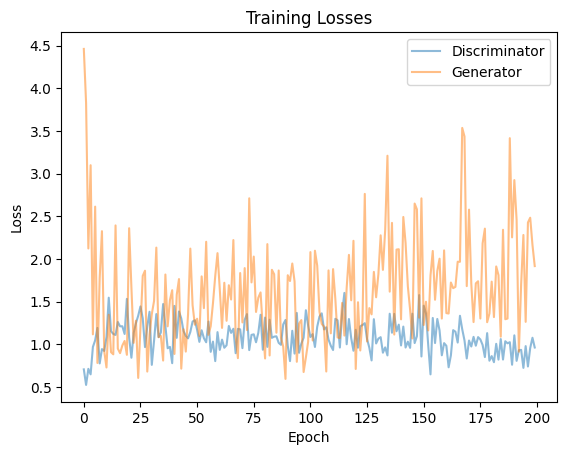

In [ ]:
plt.title("Training Losses")
plt.plot([loss[0] for loss in training_losses], label='Discriminator', alpha=0.5)
plt.plot([loss[1] for loss in training_losses], label='Generator', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

* Overall, the loss values of the two models suffer from significant fluctuation, however, the loss difference between them seems to decrease in later epochs.

* For Discriminator, we can see its loss decreases and stabilizes over time, indicating effective learning.

* For Generator, the loss seems to be exploded at some first epochs, and also fluctuates significantly and shows an increasing trend, suggesting the generator struggles more as the discriminator improves, which is expected. However, that doesn't mean that the Generator is worse since their loss difference is not significant.

### View training generations

In [ ]:
def plot_generations(samples, title=None, ax_titles=None, color_condition=None, max_cols=8):
    num_images = len(samples)
    num_cols = min(num_images, max_cols)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(figsize=(num_cols, num_rows),
                             nrows=num_rows, ncols=num_cols, sharey=True, sharex=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            img = samples[i]
            ax.imshow(img.reshape(28, 28), cmap='Greys_r')
            if ax_titles is not None:
                if color_condition is None:
                    ax.set_title(ax_titles[i], fontsize=8)
                else:
                    ax.set_title(ax_titles[i], fontsize=8, color="green" if color_condition[i] else "red")
        ax.axis('off')  # Hide any extra axes

    if title is not None:
        fig.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

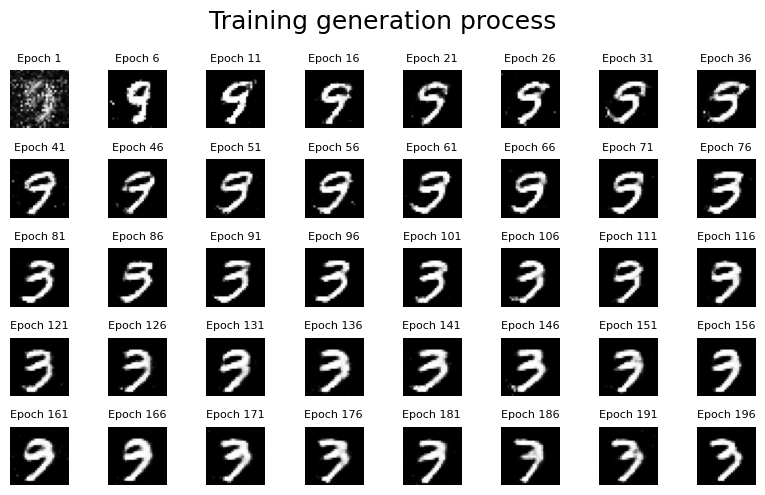

In [ ]:
batch_to_view = 12
step = 5
view_imgs = [imgs[batch_to_view][-1].cpu().detach().numpy() for imgs in training_generations[::step]]
plot_generations(view_imgs, title="Training generation process",
                 ax_titles=[f"Epoch {i * step + 1}" for i in range(len(view_imgs))])

* It can be seen that in the early epochs (< 36), the Generator has not yet eliminated noise, making it difficult to clearly identify the generated numbers. The noise level is still high, and the image quality is quite low.

* Additionally, with the same noise vector input, the generator produces different numbers after each epoch of training. This indicates that the development of the generator over time is quite unpredictable. However, the image quality still improves towards the final epochs, with images becoming sharper and less noisy.

## Save model

In [ ]:
D_cp_path = "D.pth"
G_cp_path = "G.pth"
torch.save(D.state_dict(), D_cp_path) # discriminator
torch.save(G.state_dict(), G_cp_path) # generator

## Load model

In [ ]:
D2 = Discriminator(input_dim=D_INPUT_DIM, hidden_dims=D_HIDDEN_DIMS, output_dim=D_OUTPUT_DIM, dropout_rate=DROPOUT_RATE).to(device)
G2 = Generator(input_dim=G_INPUT_DIM, hidden_dims=G_HIDDEN_DIMS, output_dim=G_OUTPUT_DIM, dropout_rate=DROPOUT_RATE).to(device)

D2.load_state_dict(torch.load(D_cp_path))
G2.load_state_dict(torch.load(G_cp_path))


<All keys matched successfully>

## Running inference

### View performance on fake images

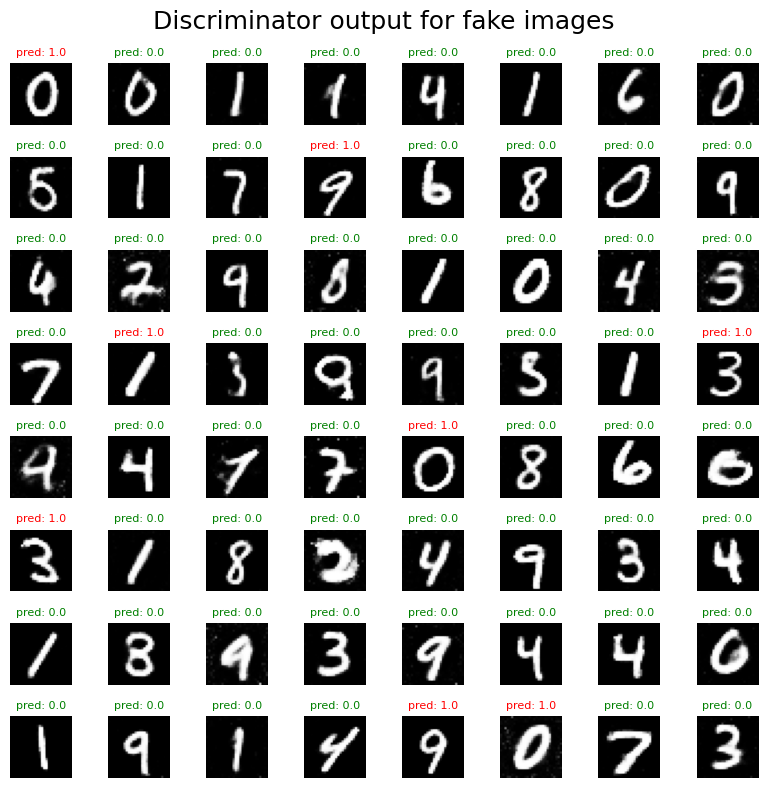

In [ ]:
# generate a batch of gaussian noises randomly
rand_z = torch.randn([BATCH_SIZE, G_INPUT_DIM], device=device)

# eval mode
G2.eval()
D2.eval()

rand_images = G2(rand_z.to(device)) # generated samples

fake_pred = D2(rand_images).detach().numpy().flatten().round()

plot_generations(rand_images.detach().numpy(),
                 title="Discriminator output for fake images",
                 color_condition=fake_pred==0,
                 ax_titles=[f"pred: {d_label}" for d_label in fake_pred])

### View performance on real images

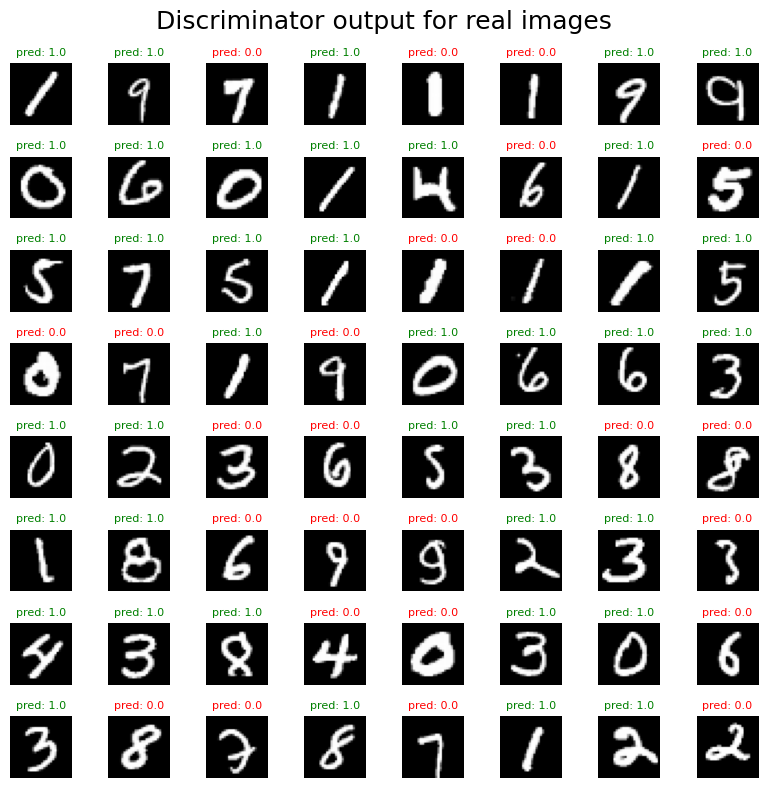

In [ ]:
for i, (real_imgs, _) in enumerate(test_dataloader):
    real_imgs = real_imgs.to(device)
    real_pred = D2(real_imgs).detach().numpy().flatten().round()
    break

plot_generations(real_imgs.detach().numpy(),
                 title="Discriminator output for real images",
                 color_condition=real_pred==1,
                 ax_titles=[f"pred: {d_label}" for d_label in real_pred])

### Summary on prediction

In [ ]:
print(f"Correct fake predictions: {len(fake_pred) - fake_pred.sum(dtype='int')} / {len(fake_pred)}")
print(f"Correct real predictions: {real_pred.sum(dtype='int')} / {len(real_pred)}")

Correct fake predictions: 56 / 64
Correct real predictions: 39 / 64


## Conclusion

* It can be seen that after a fairly long training period (200 epochs), the images generated by the generator look almost like real images. However, they still haven't completely fooled the discriminator (since the discriminator only misclassified about 14 samples). Explanation: Most generated images, although quite similar to real images, still have some issues such as blurriness, noise, and lack of sharpness in the details...

* To check if the Discriminator model is overly labeling fake images, in next figure ("Discriminator output for real images"), I added an additional step where the discriminator differentiates real images. The results are quite good as the model correctly predicts most samples, indicating that the model has good performance in distinguishing both real and fake images.

## References

* Guide: PRACTICE #02: Generative Adversarial Networks - LQN, NMH
* https://www.kaggle.com/code/datntrong/gan-mnist#X%C3%A2y-d%E1%BB%B1ng-m%C3%B4-h%C3%ACnh
* https://nttuan8.com/bai-1-gioi-thieu-ve-gan/